In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [84]:
train_data = pd.read_csv('Project2_Train.csv')
test_data = pd.read_csv('Project2_Test.csv')
test_data = test_data.rename({'Damage': 'VehicleDamage'}, axis=1)

# np.unique(train_data['Response'], return_counts = True)
combined = pd.concat([train_data, test_data], ignore_index = True)
print(train_data)

train_data, test_data = train_test_split(combined
                                         , stratify = combined['Response'], shuffle = True, test_size = 0.5, random_state = 1313)

train_data.reset_index(inplace = True)
test_data.reset_index(inplace = True)

# print(train_data)
# set_train_indices = set(np.random.choice(range(0, 20000), size=10000, replace=False, p=None))
# train_indices = [i in set_train_indices for i in range(20000)]
# test_indices = [i not in set_train_indices for i in range(20000)]

# train_data = combined[train_indices].reset_index()
# test_data = combined[test_indices].reset_index()

      Unnamed: 0      id  Gender  Age  Region_Code      Age.1 VehicleDamage  \
0              1  319654    Male   22           46   < 1 Year           Yes   
1              2  298528  Female   40           28   1-2 Year           Yes   
2              3  120858    Male   25           28   1-2 Year           Yes   
3              4  234326  Female   25           29   < 1 Year            No   
4              5  372307  Female   70           28   1-2 Year            No   
...          ...     ...     ...  ...          ...        ...           ...   
9995        9996   93671    Male   28           41   < 1 Year           Yes   
9996        9997  366284    Male   43           46  > 2 Years           Yes   
9997        9998  369037  Female   46           28   1-2 Year            No   
9998        9999  268384  Female   21           30   < 1 Year            No   
9999       10000   58856  Female   20           11   < 1 Year            No   

      Premium  Vintage  Response Mystery  
0       

In [85]:
def preprocess(data, oneHotEncodedCategories, drop_mystery):
    return_data = data.copy()
    for cat in oneHotEncodedCategories:
        encoder = OneHotEncoder()
        encoder_df = pd.DataFrame(encoder.fit_transform(return_data[[cat]]).toarray())
        encoder_df.columns = [cat + " " + name.split('_', 1)[1] for name in encoder.get_feature_names()]
        return_data = return_data.join(encoder_df)
        return_data.drop(cat, axis = 1, inplace = True)
    if drop_mystery:
        return_data.drop('Mystery', axis = 1, inplace = True)
    return return_data

In [86]:
X_train_before = train_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_train = train_data['Response']
X_test_before = test_data[['Gender', 'Age', 'Region_Code', 'Age.1', 'VehicleDamage', 'Premium', 'Vintage', 'Mystery']]
y_test = test_data['Response']

X_train = preprocess(X_train_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)
X_test = preprocess(X_test_before, ['Gender', 'Region_Code', 'VehicleDamage', 'Age.1'], True)

In [77]:
def train_one_model(estimator, param_grid):
    grid_rf_class = GridSearchCV(
        estimator = estimator,
        param_grid = param_grid,
        scoring = 'roc_auc',
        n_jobs = 3,
        cv = StratifiedKFold(),
        refit = True,
        return_train_score = True
    )
    
    grid_rf_class.fit(X_train, y_train)
    
#     print(grid_rf_class.cv_results_)

    return grid_rf_class

#     return (grid_rf_class.best_score_, grid_rf_class.best_params_, grid_rf_class.best_estimator_)

In [94]:
estimator_names = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boost"]
estimators = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

diff_weights = np.linspace(0.0, 1, 7)

param_grids = [{
#                    'class_weight': [{0: w, 1: (1 - w)} for w in diff_weights]
               }, 
               {
#                    'class_weight': [{0: w, 1: (1 - w)} for w in diff_weights],
                   'max_depth': [2, 3, 4, 5, 6, 7]
               },
               {
                   'n_estimators': [10, 50, 100],
                   'max_depth': [2, 3, 4, 5, 6, 7]
               },
               {},
               {
                   'learning_rate': [0.01, 0.05, 0.1, 0.2],
                   'n_estimators': [40, 55, 70, 100],
                   'max_depth': [2, 4, 7, 10]
               }
              ]

# for i in range(0, len(estimators)):
for i in range(0, 3):
    print('--------------------------')
    grid_rf_class = train_one_model(estimators[i], param_grids[i])
    
    print(estimator_names[i])
    
    print('best cv score: ' + str(grid_rf_class.best_score_))
    print('best params: ' + str(grid_rf_class.best_params_))
    
    y_pred = grid_rf_class.best_estimator_.predict(X_test)

    print('roc auc score of test: ' + str(roc_auc_score(y_test, y_pred)))
    print('--------------------------')

--------------------------
Logistic Regression
best cv score: 0.8115591692276635
best params: {}
roc auc score of test: 0.5041596601659225
--------------------------
--------------------------
Decision Tree
best cv score: 0.8108210437699592
best params: {'max_depth': 6}
roc auc score of test: 0.500638047929834
--------------------------
--------------------------
Random Forest
best cv score: 0.819686495332221
best params: {'max_depth': 7, 'n_estimators': 100}
roc auc score of test: 0.5
--------------------------


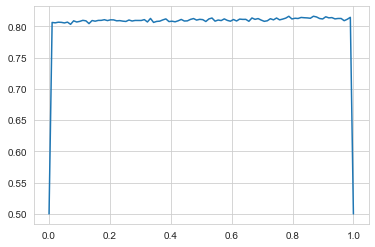

In [88]:
diff_weights = np.linspace(0.0, 1, 100)
weights = [{0: w, 1: (1 - w)} for w in diff_weights]

scores = []

for w in weights:
    kf = StratifiedKFold(n_splits = 10, shuffle = True)
    model = DecisionTreeClassifier(max_depth = 5, class_weight = w, random_state = 1313)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc')
    scores.append(np.mean(cv_scores))

plt.plot(diff_weights, scores)
plt.show()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 429 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.1s finished


Text(0.5, 1.0, 'Scoring for different class weights')

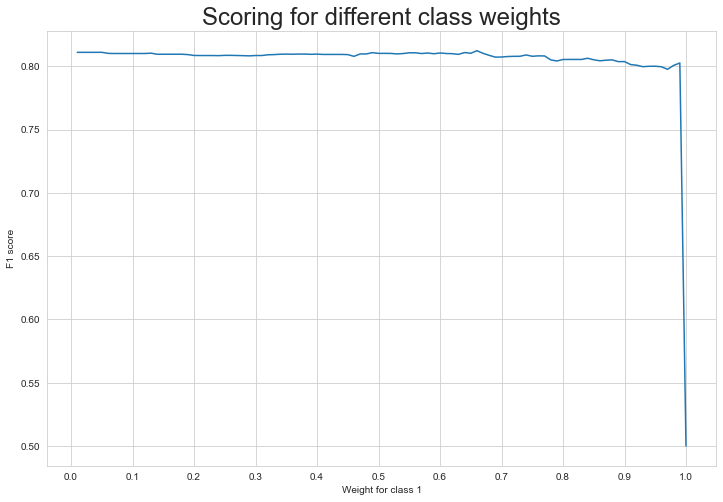

In [90]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
lr = DecisionTreeClassifier(max_depth = 5)

#Setting the range for class weights
weights = np.linspace(0.0,0.99,100)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='roc_auc', 
                          verbose=2).fit(X_train, y_train)

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)